<div align="center">

# k‑ближайших соседей  
## (k‑Nearest Neighbors, kNN)  
### «ленивый» алгоритм обучения

</div>

---

**kNN** не строит явную разделяющую функцию, а «лениво» запоминает все обучающие примеры и лишь при классификации сравнивает новый объект с ними.

### Параметрические vs. непараметрические модели

- **Параметрические** (персептрон, логистическая регрессия, линейный SVM)  
  имеют фиксированное число параметров и после обучения не требуют данных.

- **Непараметрические** (деревья решений, случайные леса, ядерный SVM, kNN)  
  не ограничены заранее заданным числом параметров — их сложность растёт вместе с объёмом данных.

### Алгоритм kNN

1. Задать число соседей \(k\) и метрику расстояния.  
2. Для нового объекта найти \(k\) ближайших соседей в обучающей выборке.  
3. Отнести объект к тому классу, который преобладает среди соседей (majority vote).

Метрика расстояния определяет «близость» объектов в пространстве признаков.  

### Преимущества и недостатки подходов на основе запоминания

- **Плюсы:**  
  - Постоянная адаптация по мере поступления новых данных.  
  - Высокая простота реализации и отсутствие фазы явного обучения.

- **Минусы:**  
  - Время классификации растёт линейно с размером выборки (если нет специальных структур: k‑d tree, ball tree).  
  - При больших объёмах данных — повышенные требования к памяти и скорости поиска.

> Для небольших и средних наборов kNN часто обеспечивает конкурентоспособное качество предсказаний и остаётся простым в применении решением.

---


Реализуем kNN модель с помощью scikit-learn, использовав евклидовую метрику расстояния.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
# 1) Загрузка всех образцов Iris
iris   = datasets.load_iris()
X_all  = iris.data        # shape (150, 4)
y_all  = iris.target      # shape (150,)

# 2) Выбор двух признаков: petal length (индекс 2) и petal width (индекс 3)
X_23   = X_all[:, [2, 3]]

# 3) Стандартизация признаков
scaler = StandardScaler()
X_std  = scaler.fit_transform(X_23)

# Делим X_std_2 и y_all_2 на train и test
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_std, y_all, np.arange(len(y_all)),
    test_size=0.3,          # 30% тест
    random_state=1,
    stratify=y_all        # сохраняем пропорции классов
)


In [9]:
# Обучени модели kNN
knn = KNeighborsClassifier(n_neighbors = 5,
                           p = 2,
                           metric = 'minkowski')

knn.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))


In [10]:
# График визуализации областей принятия решений kNN
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap    = ListedColormap(colors[:len(np.unique(y))])

    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Отрисовка всех образцов
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f'Класс {cl}',
            edgecolor='black'
        )

    # Подсветка тестовых образцов, если переданы индексы
    if test_idx is not None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            X_test[:, 0], X_test[:, 1],
            facecolors='none',
            edgecolors='black',
            alpha=1.0,
            linewidth=1,
            marker='o',
            s=100,
            label='Тестовый набор'
        )

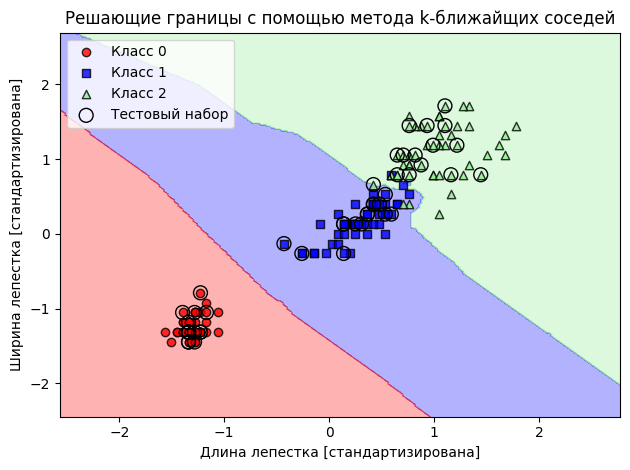

In [11]:
plot_decision_regions(X_combined,
                      y_combined,
                      classifier = knn,
                      test_idx = range(105, 150))
plt.xlabel('Длина лепестка [стандартизирована]')
plt.ylabel('Ширина лепестка [стандартизирована]')
plt.title('Решающие границы с помощью метода k-ближайщих соседей')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

## Выбор параметра \(k\) и метрики расстояния

- **Баланс между переобучением и недообучением**  
  Правильный выбор \(k\) позволяет найти оптимальный компромисс:  
  - Малые \(k\) могут приводить к шумному решению и переобучению.  
  - Большие \(k\) размывают локальную структуру и ведут к недообучению.

- **Метрика расстояния**  
  Важно подобрать меру, соответствующую природе признаков:
  - **Евклидово расстояние** часто применяется, когда все признаки измерены в одной шкале (например, сантиметры в наборе Iris).  
  - **Стандартизация** обязательна при использовании евклидовой метрики, чтобы каждый признак вносил равный вклад.

## Расстояние Минковского

Обобщённая формула расстояния Минковского:
$$
d\bigl(x^{(i)}, x^{(j)}\bigr) \;=\; \sqrt[p]{\sum_{k=1}^{n} \bigl|x_k^{(i)} - x_k^{(j)}\bigr|^p}
$$

- \(p = 1\) → манхэттенское расстояние  
- \(p = 2\) → евклидово расстояние  
- В `scikit-learn` доступны и другие метрики (Чебышёва, косинусное расстояние и др.).

## Проклятие размерности и методы борьбы

- **Проклятие размерности**: при большом числе признаков фиксированный объём выборки становится разреженным, и даже ближайшие соседи могут располагаться слишком далеко.  
- **Регуляризация** помогает в линейных моделях, но для kNN и деревьев решений применяют:
  - **Отбор признаков** (feature selection)  
  - **Снижение размерности** (PCA, t-SNE и пр.)

## Ускорение вычислений на GPU

При работе с большими данными и сложными моделями (kNN, случайные леса) стандартный CPU может оказаться недостаточно быстрым. Если у вас есть NVIDIA‑GPU с поддержкой CUDA, рассмотрите экосистему **RAPIDS**:

- **cuML** — GPU‑реализации алгоритмов `scikit-learn`, включая kNN и случайные леса, для значительного ускорения обучения и предсказания.  

---

## Заключение

Мы рассмотрели основные алгоритмы машинного обучения и их сильные стороны:

- **Деревья решений**  
  Позволяют легко интерпретировать логику принятия решений и выявлять важные признаки. Благодаря простоте структуры они хорошо подходят для объяснимых моделей, однако могут склоняться к переобучению на малых выборках.

- **Логистическая регрессия**  
  Эффективна в задачах бинарной классификации, поддерживает онлайн‑обучение алгоритмом SGD и сразу выдаёт оценку вероятности каждого класса. При правильной регуляризации устойчиво работает на данных со множеством признаков.

- **Метод опорных векторов (SVM)**  
  В линейном варианте обеспечивает высокую обобщающую способность, а при применении «ядерного трюка» — легко адаптируется к сложным нелинейным зависимостям. Основной недостаток — необходимость тщательного подбора ядра и гиперпараметров.

- **Ансамблевые методы (случайные леса)**  
  Объединяют множество слабых деревьев, минимизируют переобучение и редко требуют тонкой настройки. Это делает их надёжным выбором в разнообразных прикладных сценариях без глубокого анализа гиперпараметров.

- **kNN (к‑ближайших соседей)**  
  Не требует этапа обучения: все вычисления откладываются на стадию предсказания. Такой «ленивый» подход упрощает реализацию, но может оказаться ресурсоёмким при больших объёмах данных и высоких размерностях признаков.

В любом случае **качество данных** остаётся решающим фактором: ни один алгоритм не выдаст точных прогнозов без информативных, хорошо предобработанных признаков.
